In [11]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import plotly.express as px
import pmdarima as pm
from pmdarima import arima
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import matplotlib.pylab as plt
from pmdarima import utils

# Time Series modeling typical process

1. **Data re-sampling, Raw data confirmation, Confirm Trend and Seasonality raw data.**
    - Data re-sampling example: Re-sample daily data to monthly aggregation data.
    - Raw data confirmation
        - Identify outlier, missing value, structural breaks, significant trend change.
    - Confirm Trend and Seasonality
        - Identify stationarity, trend seasonality by using time series decomposition.
2. **Data prcessing to make it stational process**
    - Differencing
        - Idea of differencing example: $w_t = y_t - y_{t-1}$
    - Detrending
        - Detrending by constructing a piece-wise (linear) regression with time 't' as an explanatory variable and taking residuals.
    - Logarithm
        - Once exponential growth is confirmed in process, logarithm is one option to utilize with Differencing/Detrending technique.
3. **Check Stationarity (Argumented Dicky Fuller test)**
    - Null hypothesis: Non Stationarity exists in the series.
    - Alternative Hypothesis: Stationarity exists in the series
    - https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test
4. **Check ACF(Auto correlation function) / PACF(Partial auto correlation function)**
    - Compare with Theoretical ARMA process to determine p, d, q
        - i.e) Differentiating is necessary when the ACF is gently decaying, p should be negative value when the ACF is oscilating etc.
5. **Find parameter of ARIMA / SARIMA**
    - The parameters p, d, q, P, D, and Q can either be fully automatic, in which all combinations are modeled and the parameters with the lowest AIC are adopted, or semi-automatic, in which d, D, etc. are determined manually in step 2, etc. and p, q, P, and Q are searched. In practical, parameter 'm', which indicates seasonality, is set to 12 or so.
6. **Verify and Forecast**
    - Check QQ plot of residual (Check normality)
    - Check ACF / PACF of residual (Should look like a white noise)
    - Check AIC / BIC
    - Check MAPE, RMSE

Data: https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data?select=train.csv  
Further explanation: https://www.youtube.com/watch?v=Y2khrpVo6qI


# General tips

- Sample equation of ARIMA(1,0,1)(2,1,0)12
$$
ARIMA(p, d, q)(P, D, Q)_{season} = ARIMA(1,0,1)(2,1,0)12 \\
y_t - y_{t-12} = w_t \\
w_t = intercept + \alpha_1 w_{t-1} + \alpha_2 w_{t-12} + \alpha_3 w_{t-24} + \beta_1 e_{t-1} + e_t \\
 == intercept + AR(p=1) + AR(P=1 of 2) + AR(P=2 of 2) + MA(q=1)
$$

- General equation of SARIMAX  

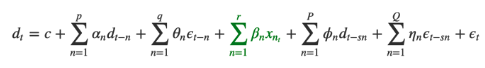

    * X of SARIMAX: highlighted in green  
    * Reference: https://towardsdatascience.com/a-deep-dive-on-arima-models-8900c199ccf


- ACF / PACF of theoretical ARMA process 


|    |     ACF      | PACF |
| --- | ----------- | ------- |
| AR(p)| Tail off exponentially | Cut off after lag p|
| MA(q)| Cut off after lag q | Tail off exponentially|
| AR(p)MA(q)| Tail off exponentially | Tail off exponentially|
| SAR(p)MA(q)| Tail off exponentially | Cut off after lag p*m|
| SMA(q)| Cut off after lag q*m | Tail off exponentially|
| SAR(p)MA(q)| Tail off exponentially | Tail off exponentially|



# 1. Data re-sampling, Raw data confirmation, Confirm Trend and Seasonality raw data

,date,store,sales
0,2013-01-01,1,1316
1,2013-01-02,1,1264
2,2013-01-03,1,1305


,date,sales
0,2013-01-31,41077
1,2013-02-28,41306
2,2013-03-31,55827


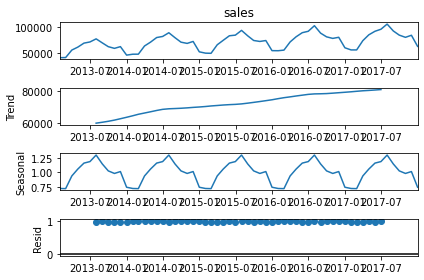

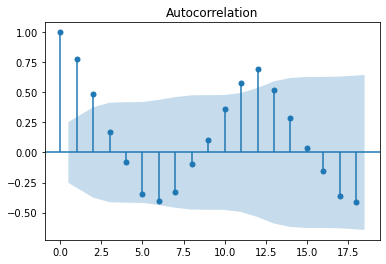

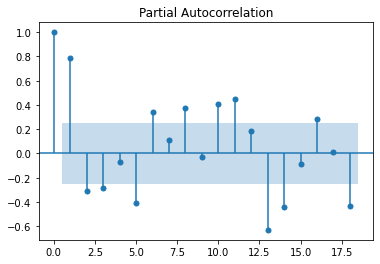

In [12]:
df = pd.read_csv('./data/train.csv')
df = df[df['store']==1].groupby(['date', 'store'])[['sales']].sum().reset_index()
display(df.head(3))
df['date'] = pd.to_datetime(df['date'])
df = df.resample('M', on='date').sum().reset_index()[['date','sales']] #daily -> monthly resampling
display(df.head(3))

df.set_index('date',inplace=True)
df.index=pd.to_datetime(df.index)
seasonal_decompose(df['sales'], model='multiplicable', period=12).plot()
plt.show()

utils.plot_acf(df, alpha=.05)
utils.plot_pacf(df, alpha=.05)

Finding:
- Non-stational
- Trend exist
- Seasonality exsist

# 2. Data prcessing to make it stational process

d = 1
D = 1


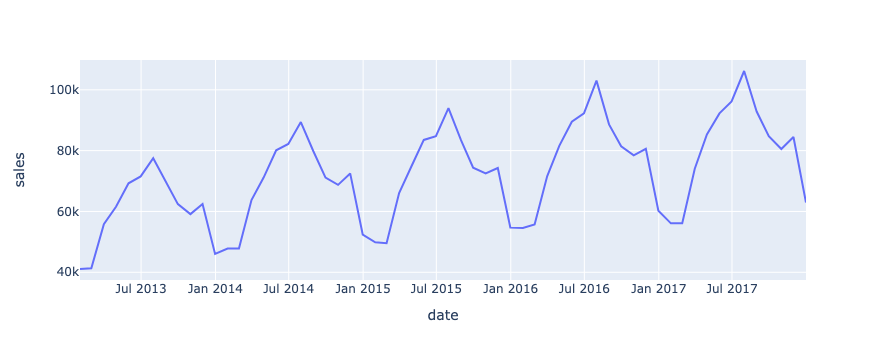

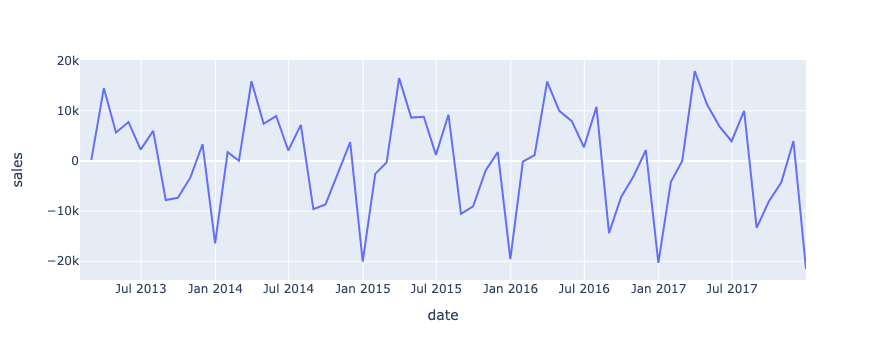

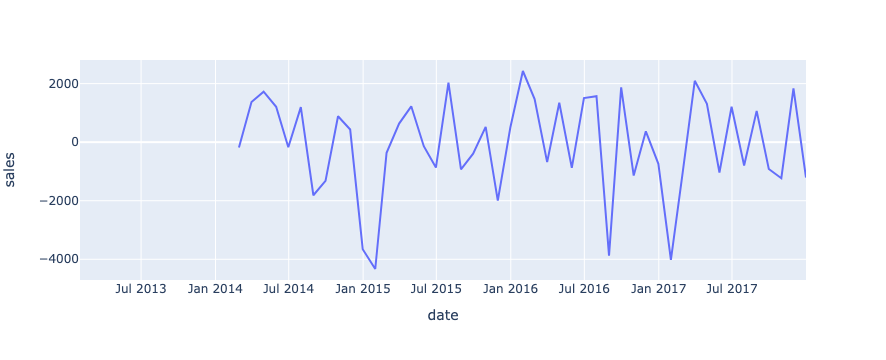

In [13]:
print('d =', arima.ndiffs(df)) #find d (montly differencing)
print('D =', arima.nsdiffs(df,m=12)) #find D（yearly differencing）
fig = px.line(df.reset_index(), x='date', y='sales')
fig.show()
fig = px.line(df.diff(1).reset_index(), x='date', y='sales')
fig.show()
fig = px.line(df.diff(1).diff(12).reset_index(), x='date', y='sales')
fig.show()


# 3, 4. Check Stationarity, ACF, PACF
ADF test (adfuller test)
- Null hypothesis: Non Stationarity exists in the series.
- Alternative Hypothesis: Stationarity exists in the series

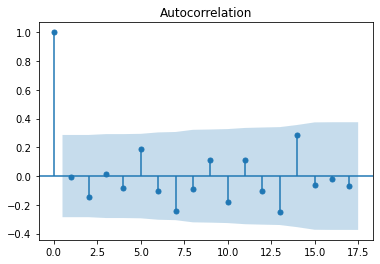

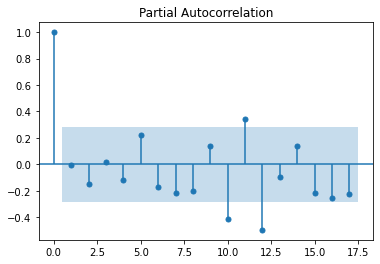

ADF Statistic: -1.722612
p-value: 0.419502
Critical Values:
	1%: -3.627
	5%: -2.946
	10%: -2.612


In [14]:
df_d1_d12 = df.diff(1).diff(12)
utils.plot_acf(df_d1_d12.dropna(), alpha=.05)
utils.plot_pacf(df_d1_d12.dropna(), alpha=.05)
import statsmodels.api as sm
adm = sm.tsa.stattools.adfuller(df_d1_d12.dropna())
print('ADF Statistic: %f' % adm[0])
print('p-value: %f' % adm[1])
print('Critical Values:')
for key, value in adm[4].items():
    print('\t%s: %.3f' % (key, value))

Still process is not stational (p>>0.05). 2014-12, 2014-01, 2016-08 and 2017-01 are obviously breaking the stationarity. It seems that those numbers should be explained by exogenous variables. In this notebook I will continue modeling for simplicity

# 5, 6. Find parameter of ARIMA / SARIMA. Verify and Predict

In [15]:
from pmdarima import model_selection
train, test = model_selection.train_test_split(df, train_size=48)
arima_model = pm.auto_arima(train, seasonal=True, m=12, d=1, D=1, n_jobs=-1, maxiter=20, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=616.830, Time=0.22 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=619.729, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=610.344, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=609.094, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=621.759, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=610.428, Time=0.08 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=610.672, Time=0.07 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=610.667, Time=0.03 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=612.013, Time=0.18 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=605.895, Time=0.03 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=606.748, Time=0.07 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=607.014, Time=0.04 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=605.516, Time=0.02 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=604.720, Time=0.10 sec
 ARIMA(0,1,0)(2,1,1)[12]         

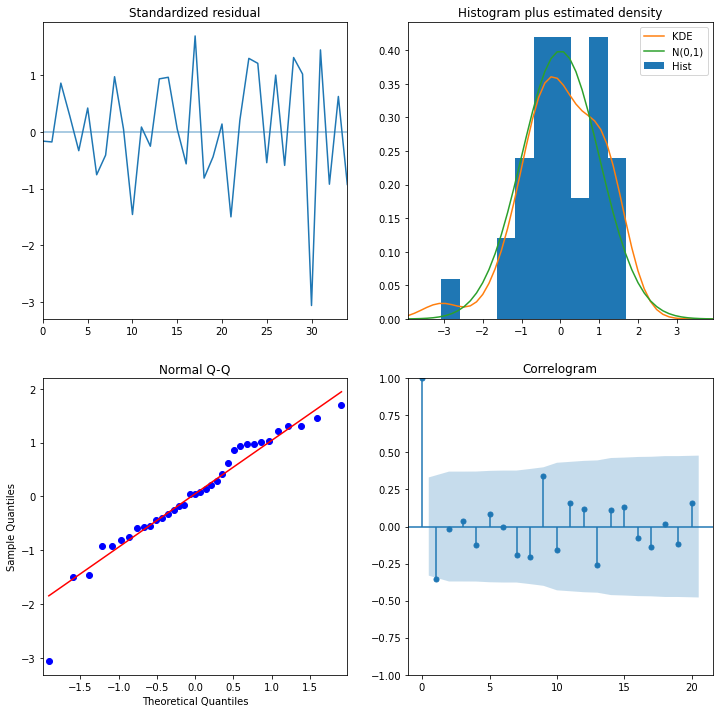

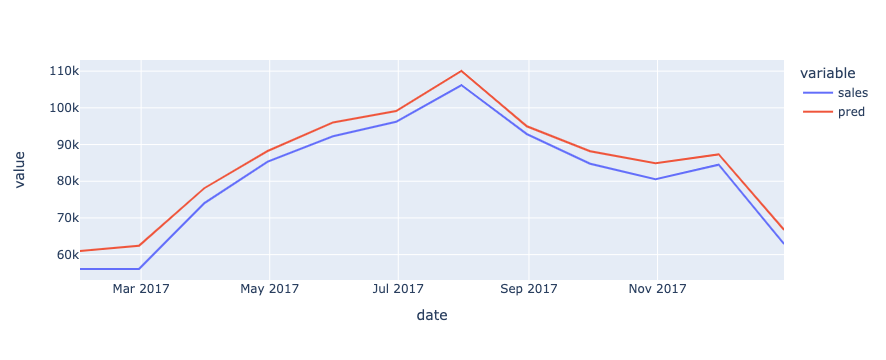

In [16]:
fig = arima_model.plot_diagnostics(lags=20, figsize=(12,12))
plt.show()
preds, conf_int = arima_model.predict(n_periods=test.shape[0], return_conf_int=True)
test['pred'] = preds
fig = px.line(test.reset_index(), x='date', y=['sales','pred'])
fig.show()
